# **7. Production-Ready Machine Learning (Bento ML)**



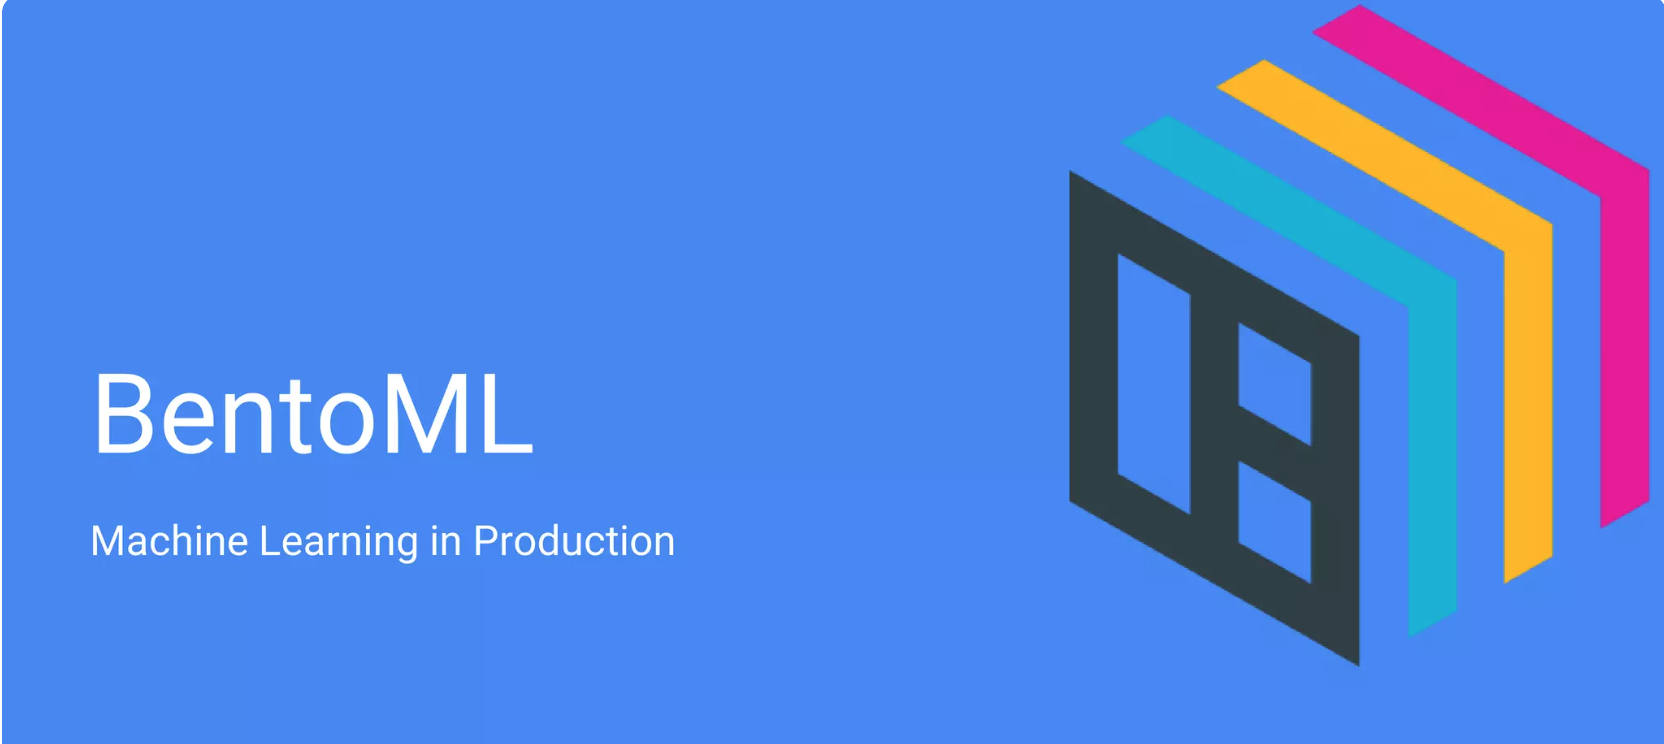

## **Instructor: Tim Liu**


## **7.1 Intro/Session Overview** (video 1)


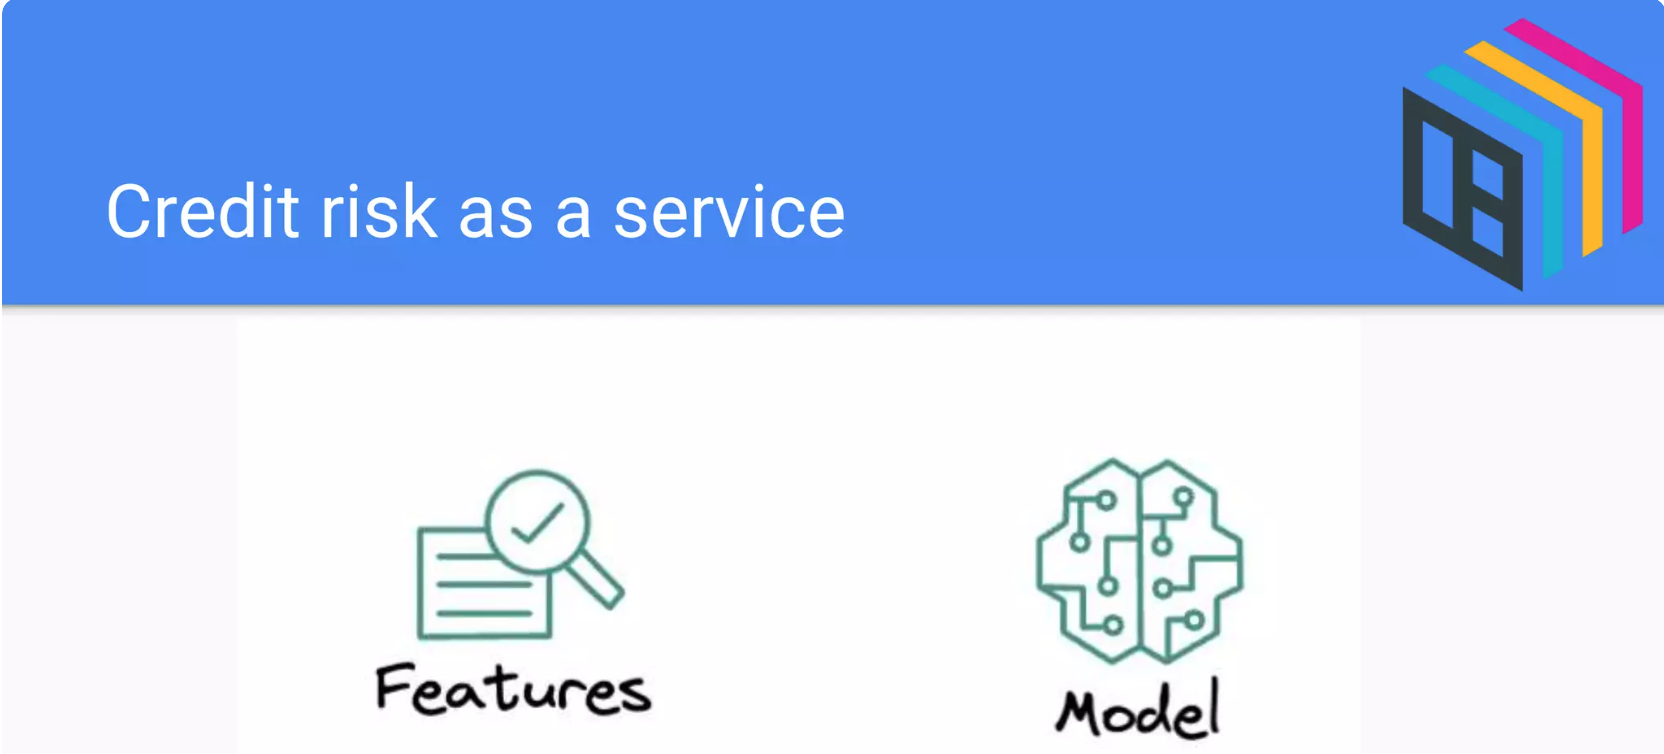

* Alright… so let’s review a little bit what we did in module 6

We cleaned a known dataset of people who applied for credit We created features based on that data, And finally, we created a few models and picked the one that performed the best

Great job to everyone who got through module 6, it’s a real live use case that I see all time, typically this is the type of data you start with, then you expand the model with others as well.

So if this was part of your real job, where would you go from here now that you’ve trained your model.

How do you get it into the hands of real people who are applying for credit?

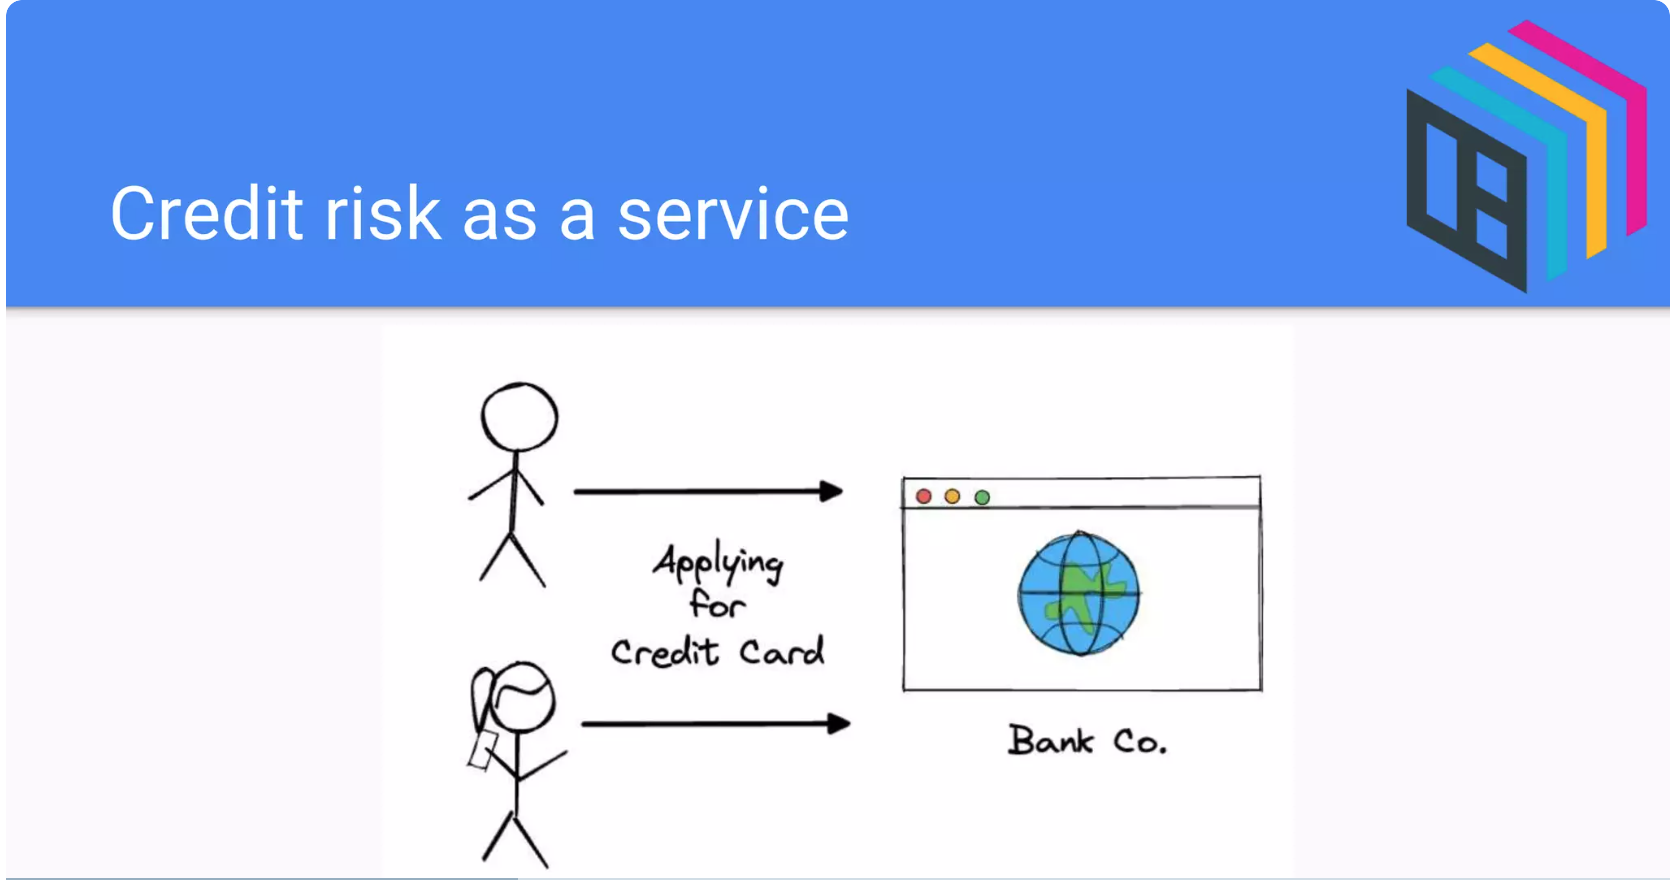

* Well first we know that most people applying for credit are probably applying online.

It’s also likely that if you work for a lender, they have a primary website where this is taking place.

In the olden days… turnaround for something like credit approval could take days, but with your new prediction model, now it’s going to be almost instantaneous.

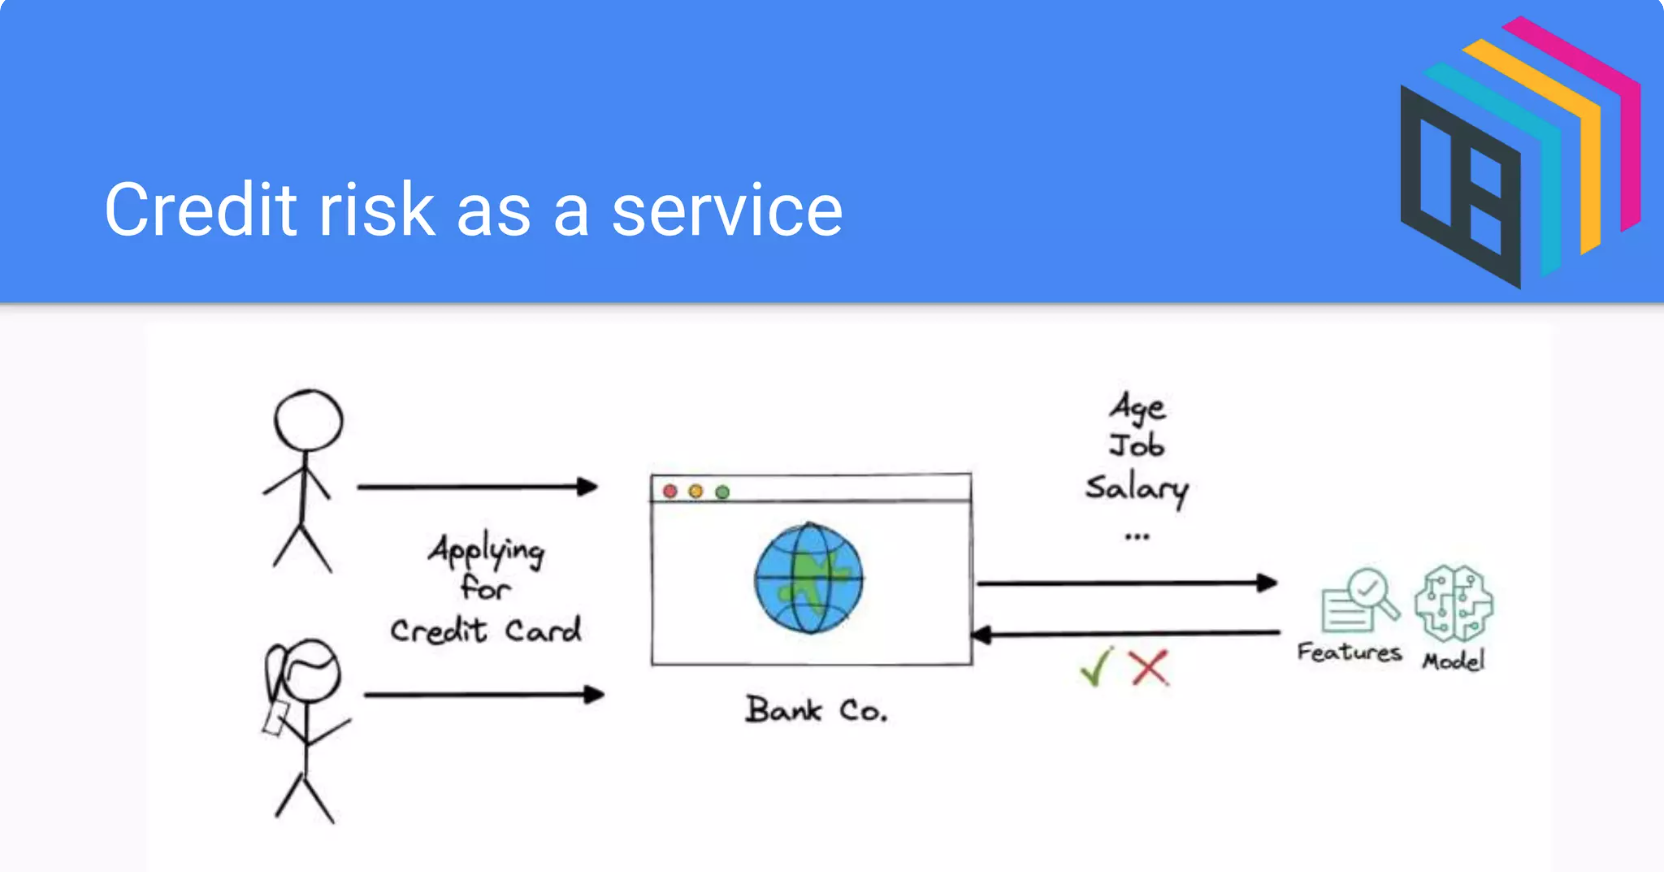

* So how do we connect people applying for credit on a website
With your new model?

It’s likely their filling out an application. Let’s say the data is identical to the data which the model uses

Age, job, salary along with all the other data points.




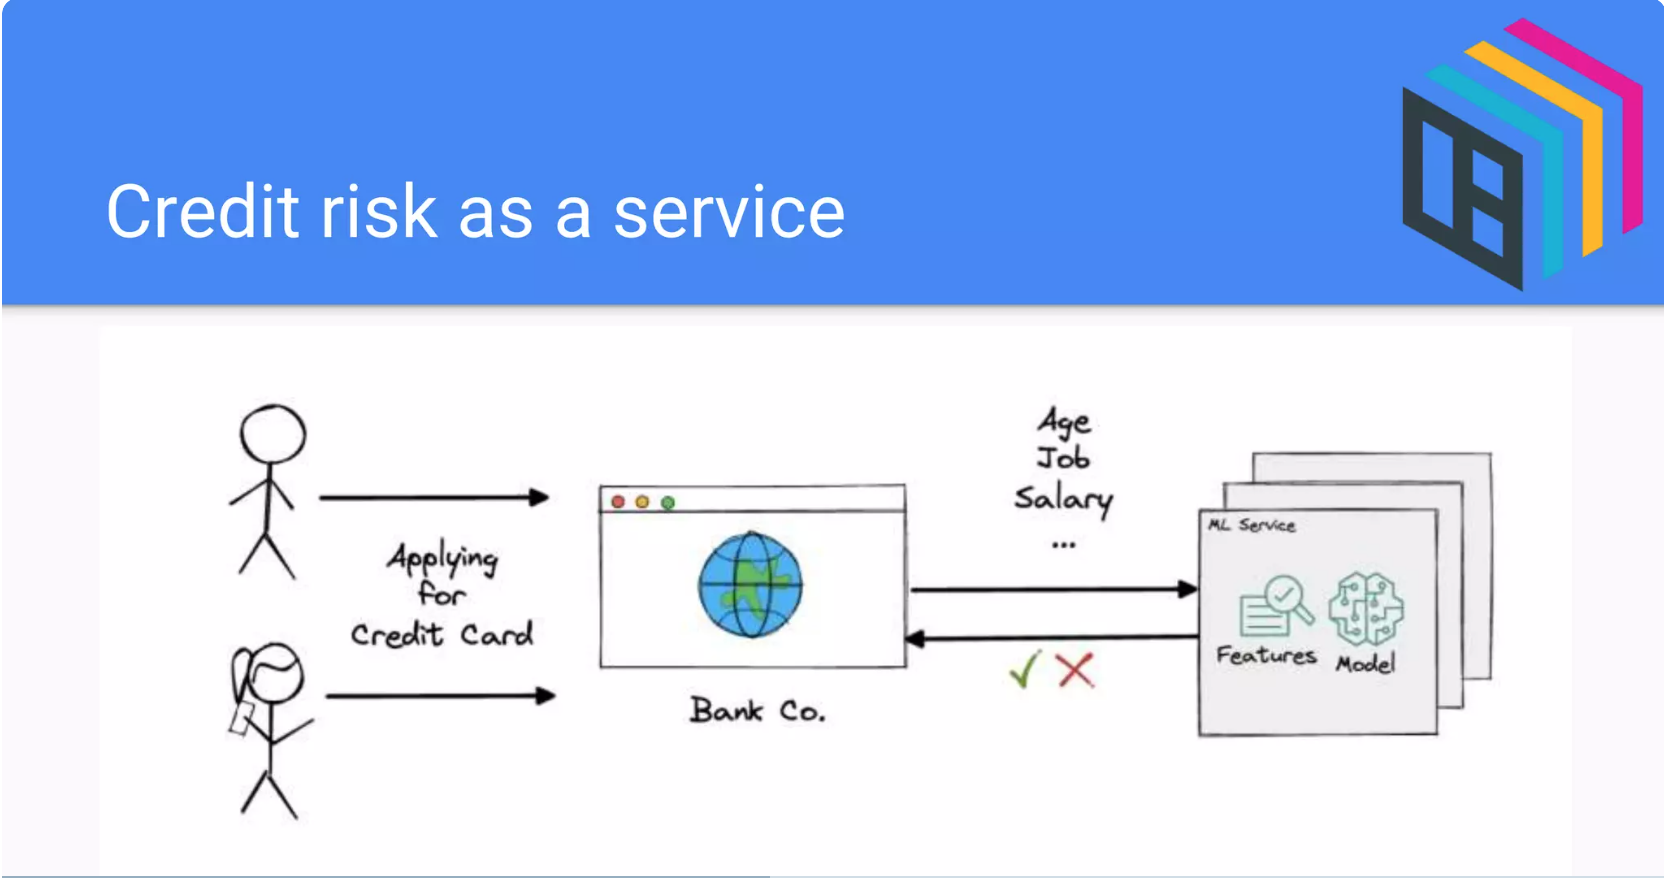

* One thing we took a quick look at in module 5 was how to pickle our model and create a Flask app that can be used to expose an API the endpoint which serves predictions.




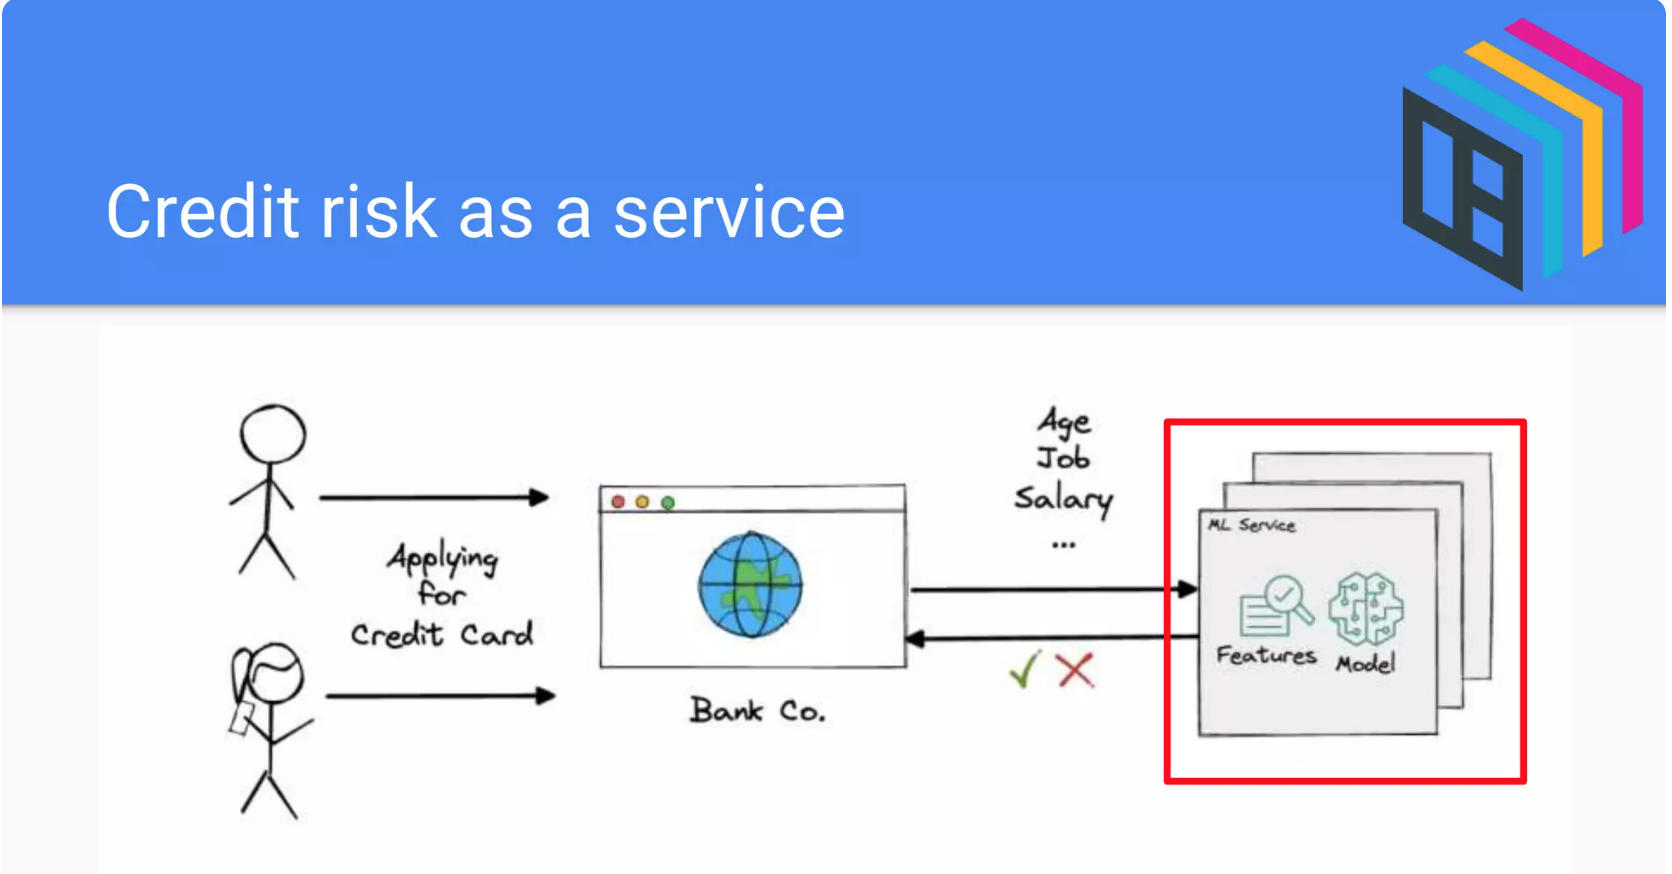

* While this works well in development, in the real world there are a lot of other factors to consider when we are building our service to ensure it is ready for production-level traffic.

What do I mean by that? Well, talking from a strictly practical point of view, it means that instead of a handful of people trying out your API, it could be hundreds, thousands, or even more depending on the use case.

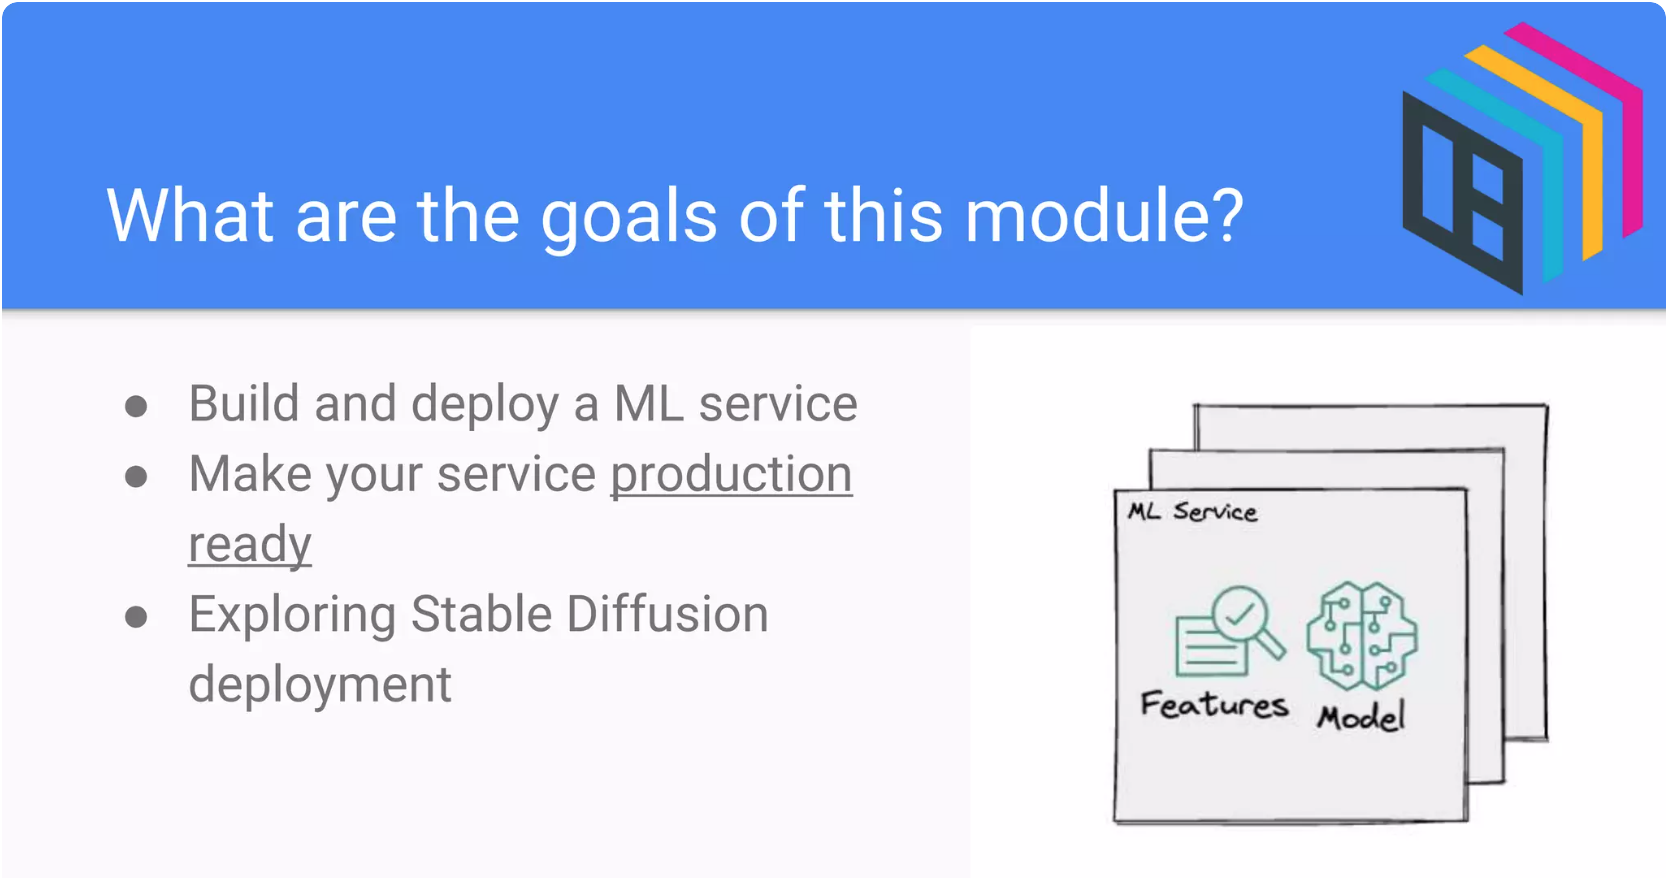

In this module, we’re going to focus on how to build, package and deploy your machine learning service at scale.

First, we’re going to show you how to build and deploy your ML service with BentoML Then we’re going to make sure you know how to ensure your service is production ready Finally we’ll go through an advanced project which deploys the latest stable diffusion model.

So that whether you’re deploying this credit risk model, or the latest, coolest ML model, you’ll have a standard way of deploying your ml models.

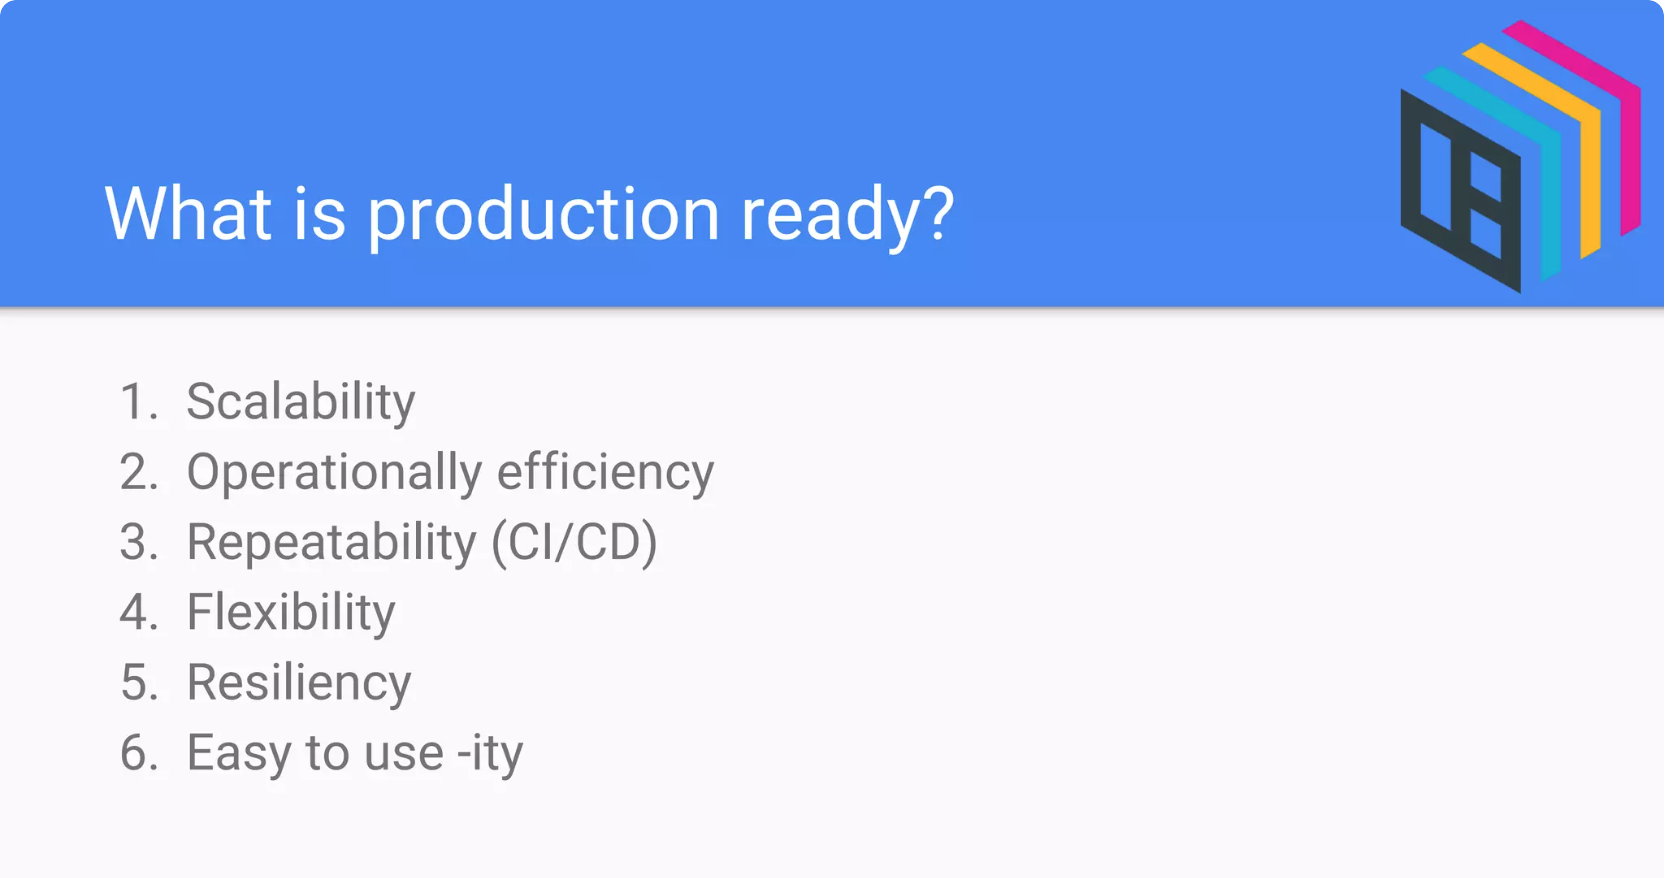

So we’re going to use the phrase “production” a lot in the upcoming modules. That can mean a bunch of things to a bunch of different people.

Let me define some attributes which we’ll be addressing, and I’ll go through these quickly

Scalability is one we just talked about

Operational efficiency -> this is the point where if I had a life audience I might ask what you think this is It’s being able to maintain your service without it having to be your full time job When you first deploy your service to production, that’s day one of the rest of the service’s life What about when it breaks, or you need to update the code, or the model what if you need to update the model every week?

Which is what repeatability means, making sure you can update it easily, or even repeat building a similar service without having to do everything again.

Flexibility is going to be your escape hatch if you ever need to react to late-stage requirement changes or issues in production that were unforeseen.

Resiliency will make sure that even if you completely blow up your service, you should be able to easily go back to the stable one.

And in everything that we do, BentoML believes that all great frameworks need to be easy to use, not sure this corresponds to production ready, but we think it does.

As a final word here, don’t feel like you need to worry about all this on your first day, getting the service deployed in the first place is a huge win start with that and the rest will come.

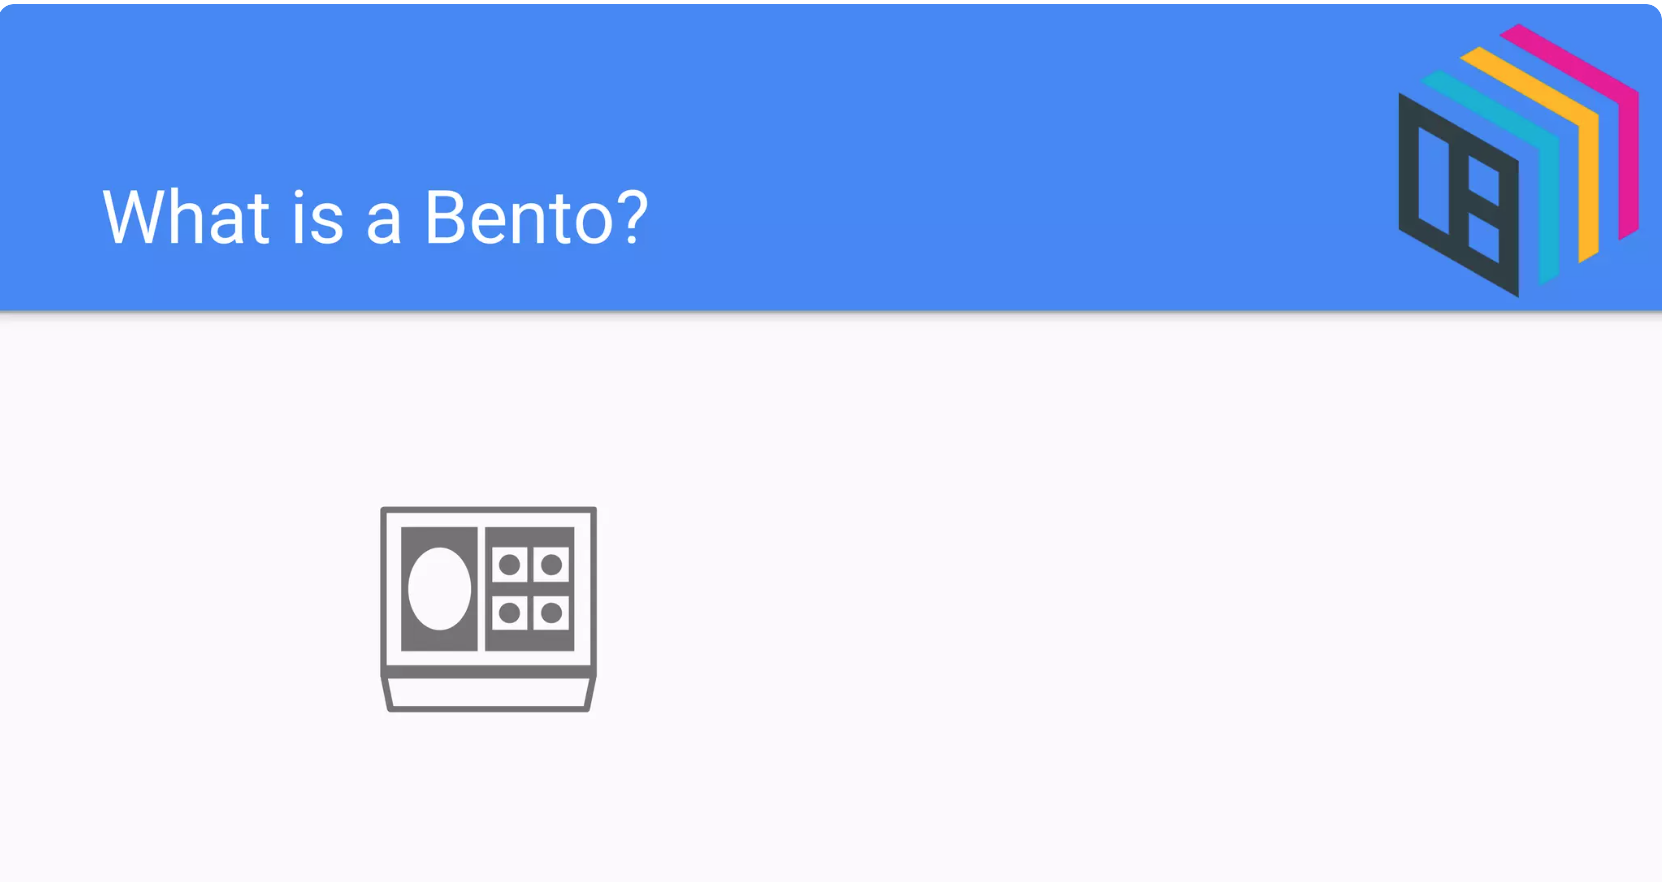


* So… let’s get started at the beginning. What in the heck is a bento?

Wikipedia says “A bento (弁当, bentō)[1] is the Japanese iteration of a single-portion take-out or home-packed meal, often for lunch”. 

Now typically the way you can identify these Bentos is by their unique design where different courses in the meal are separated into different compartments, but all part of the “bento box”.

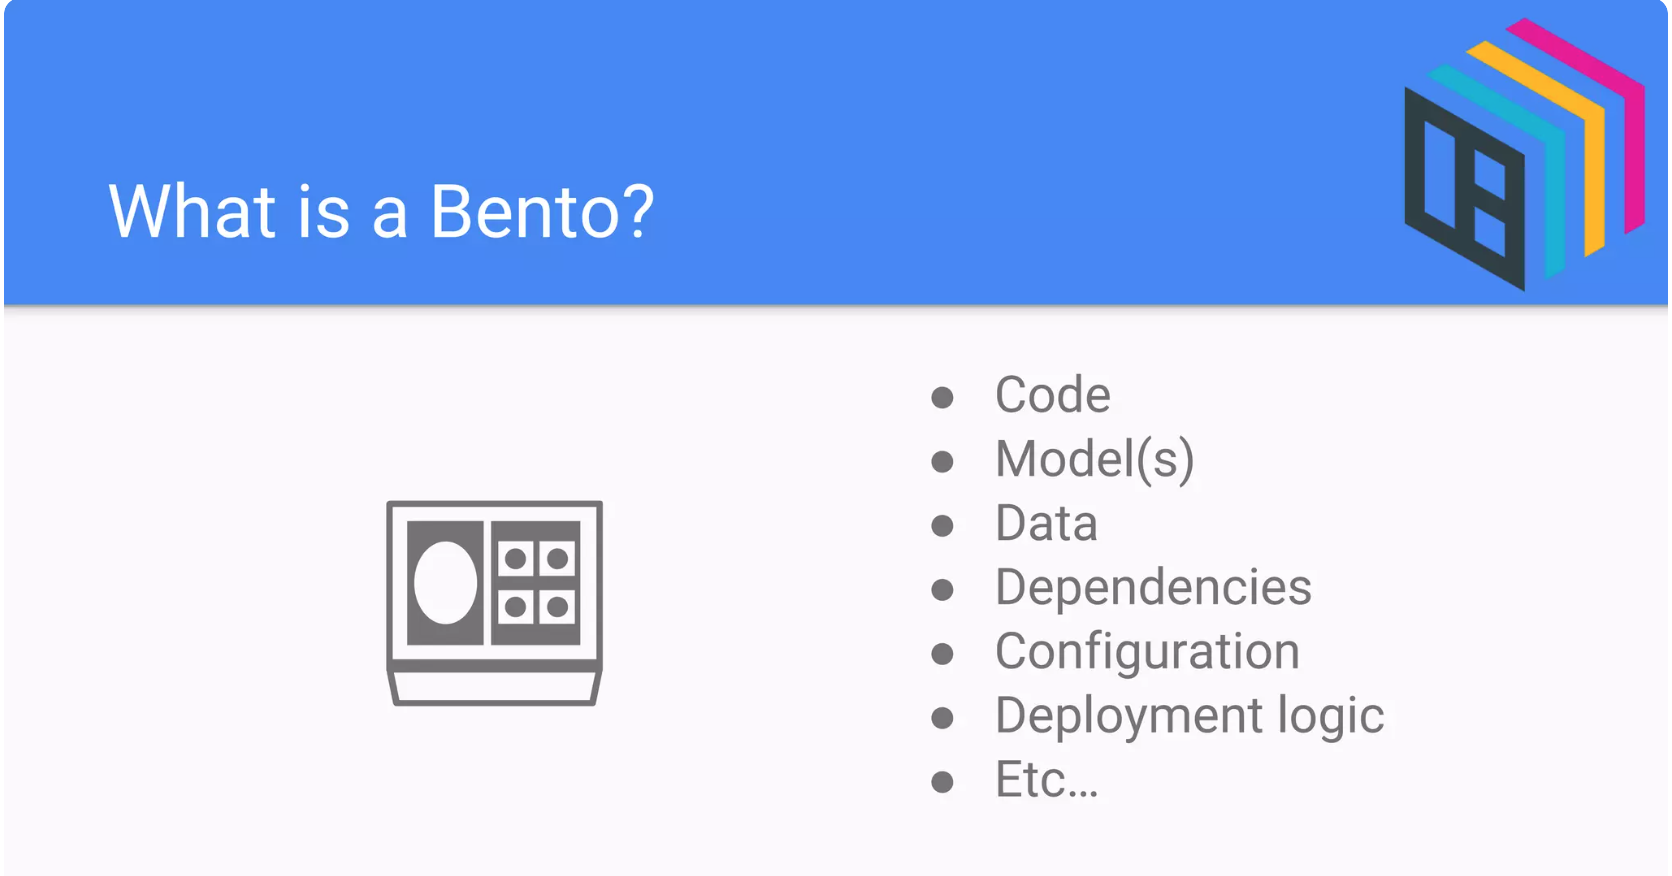

Ok, so now you’re asking yourself… how does this relate to machine learning in production?

A typical machine learning service, as you might have guessed contains a lot of different components, certainly more than a typical software application.

You’ve got the service code that contains which pre/post-processing logic along with all of the routing and validation logic Then you’ve got all of the various dependencies needed to run the service You may have one or potentially many models You have static data sets, Configurations, and deployment logic.

The list goes on. I’ve seen all kinds of things packed into ml services depending on the use case.

The point is, a bento is an abstraction for packaging these components into one deployable unit.



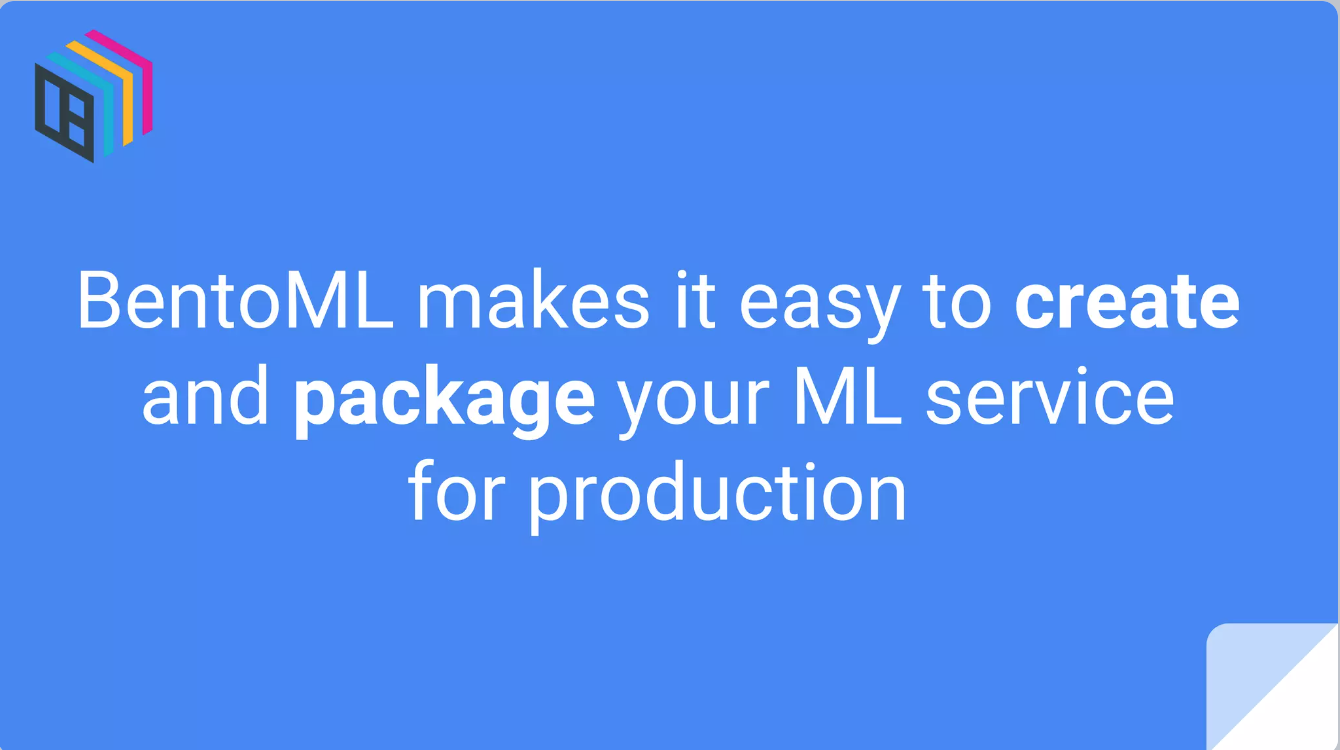

* BentoML is an open-source framework that makes it easy to create and package your production service.


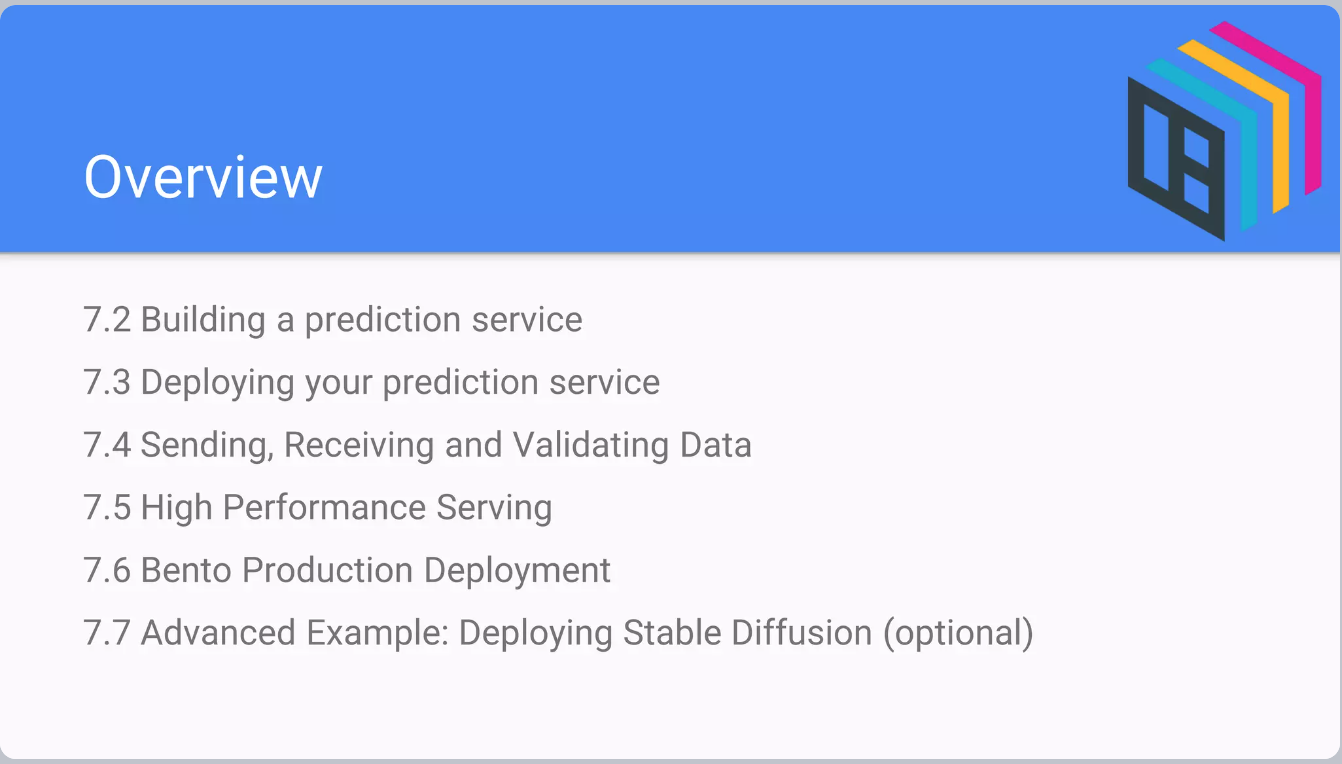

* So let's take a look at an overview of the module.

In the next 2 upcoming sections, we’re going to get hands-on showing you the fastest way to package your service and deploy it.

Then we’ll get into a little more detail about how it works and how to customize your service depending on what you need.

Then finally in 7.6 and 7.7 we’ll get high-end and talk about a bunch of different ways that you can deploy and serve at really high scale.

Then we’ll wind down with a short section on how you can create your ML abstractions if you need to.

So that’s great, thanks for listening! Let’s kick things off!

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

# **Data preparation**

In [ ]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'
df = pd.read_csv(data)

In [ ]:
df.columns = df.columns.str.lower()

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

df = df[df.status != 'unk'].reset_index(drop=True)

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=11)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

del df_train['status']
del df_test['status']

In [ ]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

# **Random forest**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

# **XGBoost**

Note:

We removed feature names

It was

features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)

Now it's

dtrain = xgb.DMatrix(X_train, label=y_train)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [ ]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [ ]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [ ]:
y_train_full = (df_train_full.status == 'default').values
y_test = (df_test.status == 'default').values

del df_train_full['status']
del df_test['status']

In [ ]:
dict_train_full = df_train_full.fillna(0).to_dict(orient='records')
dict_test = df_test.fillna(0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_full = dv.fit_transform(dict_train_full)
X_test = dv.transform(dict_test)

In [ ]:
rf_final = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)
rf_final.fit(X_train_full, y_train_full)

y_pred_rf = rf.predict_proba(X_test)[:, 1]

In [ ]:
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

num_trees = 160

xgb_final = xgb.train(xgb_params, dtrain_full, num_boost_round=num_trees)

In [ ]:
y_pred_xgb = xgb_final.predict(dtest)

In [ ]:
print(roc_auc_score(y_test, y_pred_rf))
print(roc_auc_score(y_test, y_pred_xgb))

0.8300425199159377
0.8322845901959826


# **7.2 Building Your Prediction Service with BentoML** (video 2)

* This section Xgboost model that you created in module six and we're going to build our prediction service around the model.
* The notebook from module 6, I've run the whole notebook and we're got a model here at the end.
* First thing we kind of have to think about is how to get this model into our machine learning service and run it behind an API the first thing we have to do is to save this model so that we can load it later in the service.
* In model 5 we talked about pickling a model and then loading it again inside of a flask app the problem with that approach is that depending on the machine learning framework there may be specific things that you have to do in order to save it properly even within various versions of an individual framework they may recommend different ways of saving your model it's important to look at the documentation and make sure that you're saving the model in the way that the Machine Learning framework is recommending.
* What Bento ML does is it gives you a simple way of calling a method to save the model and what it does is it actually goes through all of the things you have to do depending on the machine learning framework and depending on the version of that framework and serves it the right way.
* First is to install, to call pip install bentoml to make sure you've got the right version any 1.0 plus version.

# **BentoML**

In [ ]:
pip install bentoml

In [ ]:
import bentoml

In [ ]:
bentoml.xgboost.save_model(
    'credit_risk_model',
    model,
    custom_objects={
        'dictVectorizer': dv
    })

* labels user-defined labels for managing models, e.g. team=nlp, stage=dev.

* metadata: user-defined metadata for storing model training context information or model evaluation metrics, e.g. dataset version, training parameters, and model scores.

* custom_objects: user-defined additional python objects, e.g. a tokenizer instance, preprocessor function, model configuration json, serialized with cloudpickle. Custom objects will be serialized with cloudpickle.



* create service

# **Test**

In [ ]:
import json

In [ ]:
request = df_test.iloc[0].to_dict()
print(json.dumps(request, indent=2))

# **7.3 Deploying Your Prediction Service** (video 3)



* saving your model and packaging it up.
* Then deploying it in a Bento by creating the endpoint and testing it with the swagger UI.
* what bento ml has been doing for you behind the scenes and there we're going to build your bento and we're going to show you all the dependencies and things that get brought in automatically and then we're going to build a Docker container and run it.
* The tools that Bento ml provides it's a command line tool for kind of looking at stuff that you've saved bento that you've built.
* Example we've got models, we can list then see the model that we've saved.
* You can see your tag then the framework that you're using and the size of the model as well as the creation time.
* what we're saving for you automatically you can check out by saving bento. [% bentoml models get credit_ristk_model:].


* You can see the name and tag of the framework and version of the framework of BentoML and the python version.
* It is important to save the framework version because when you're recreating the model when you're loading it in your Bento later it needs to be with the same framework version that you use when you were training it, otherwise you could get in inconsistent results.
* It nicely uses the python version and another version if possible.
* How to build your bento?
* To specify the entry point which is service.py and the variable name for their service in the entry point.
* Using include and exclude you can specify particular python packages and you can even specify custom pip environment variables and a few other things can specify while conda, and docker options.
* All of the files inside the Bento we've got a README.md.
* We're got an open API. yaml.
* To have swagger UI we automatically generate it.
* Bento file that kind of glues everything together and then we have a few of the environmental things that we build.
* To build the docker image, % bentolml containerize service.py.


# **7.4 Sending, Receiving and Validating Data** (video 4)

* The library called pydantic is implemented by Bento ML and automatically imported as a dependency of Bento ML.
* How to create a pydantic schema to validate the incoming data that's coming in.
* Import from pydantic import BaseModel.


* what we're going to do with this class called base model is pydantic's class that we need to extend to create a data schema now we're going to create a Class A Credit Application Class that inherits from the base model so that python pydantic understands it and we're going to go and see all of our fields that we want to receive so seniority for example seniority is an integer, we want to say int home is a string, age time is an integer, and so on.
* We need to get a key-value pair out of this class pydantic gives us a nice method called **application_data = credit_application.dict()** and it will transform this class into the key-value pair we need to transform into a vector which then goes into our model and we run again. evaluate it bentoml local,[execute with bentoml local].
* It's important to check that you're still getting the same value for the prediction data running through a few different types of transform and just small things could throw the number off but we're still getting the same number.


* Let's try **"marital:"single"** if what happen [click execute bentoml) so now we actually see that a validation error for credit application marital is requred.


* Creating shape and dtype.

# **7.5 High-Performance Serving** (video 5)

* How to test service with high volumes of traffic and then going to walk through a bunch of different optimizations, and make it able to handle a fun of traffic. First, we'll need a tool to send traffic to our service.

* We'll use a tool called locust and pip install locust and then what you'll need to create is the locust file containing a sample of the data that you're going to send this is the same data that we're in using in the swagger UI and you have to inherit from an HTTP user which is a LOCUST object and then within that class, you have to create a task and we're calling task to classify and we have to say self.client.post to our classify endpoint that's where we're going to be sending our JSON it's just like the swagger UI only in this case locust going to be running it at tens hundreds or even more requests per second and there here we're defining await time between each time this user calls this classify endpoint and we're saying a random time between  0.01 and two seconds to kind of give it a little bit of feeling of inconsistency.
* To start up this locust process we're going to call the locust command on the command line.
* Here is the LOCUST UI, what this is going to be doing is it's going to be saying how many users should I startup and how fast should I start them up, I'll say one user at one user per second.



* One thing that is important to remember in this case is the default Bentoml setting for a failure if a request takes longer than one second so you can change that you can even change it to not every time out but a lot of the time the service is talking to you need a threshold at which if you can't respond in a certain amount of time then it should just fail and so our threshold at the current is a timeout of one second, peace of 0.5 requests per second so we're going to see anywhere between 0.5 and 1 point something depending on how long the user is waiting between each request.
*  We can see the request are coming through to our server all good this dashboard is meant to show kind of some statistics overall our median request latency is 18 milliseconds our 90th percentile is 23 milliseconds and then we can see 99th and the max overall.


* Let's say start a new load test - number of users 50, spawn rate 10, click ___ so we see our latencies are going  up a lot even just with 50 users we're having a lot of failures which means a lot of requests over one second so the fist optimization is the async await optimization a pattern that was popularized by node.js essentially what it means is that without async-await as we we're doing right here every time a request comes in the Bento has to service the request before getting to any other request so at service request then gets to the next request services it then gets to the next one so what it means is that every request needs to be serviced one by one what async will allow it to do is process each of these request in parallel so it can take in the first request and then begin processing it and the stop taking the second request put it on a cue to wait to be processed begin processing the first finish processing the second and kind of be doing all of these things in parallel the more deeper explanation for async await is out of the scope of this particular class I made serval attempts to describe it in simpler way and failed.
* Frameworks like fast API allow you to parallelize at the endpoint level as wll using async then to Bento ML give you the additional feature of being able to parallelize at the inference level with by calling async run rather than run.

* Go back to LOCUST, and go back to our 50 users every 10 milliseconds, and sometimes you get a failure at the very beginning because of the called start issue when a server first is started up it needs to Cache a few things before it's able to function at the highest performance so more advanced deployments will hit there service a few times ahead of time when it's starting up before it's up.
* So we're doing 49.8 requests per second pretty fast so our median is down at four milliseconds our 90th percentile is down at eight where we were completely failing before now we're blazing.
* So let's take this up a notch and go Edit **running load test**, number of users 200, 50 spawn.
* Our requests are romping but our 99th percentile is getting a bit high 230, our 90th percentile is kind of suffering a little.
* Push it a bit 300 number of users, our  99th percentile is going up more and we're kind of getting into the territory where we're closing in on some failure.
* Pust it a bit to 350, we're probably going to see a lot more failure eight percent.
* It's getting worse as we get higher.

# **7.6 Bento Production Deployment**

# **7.7 (Optional) Advanced Example: Deploying Stable Diffusion Model**

# **7.8 Summary**